<a href="https://colab.research.google.com/github/ppannala/SFDC-Ship/blob/master/NLP_Project_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

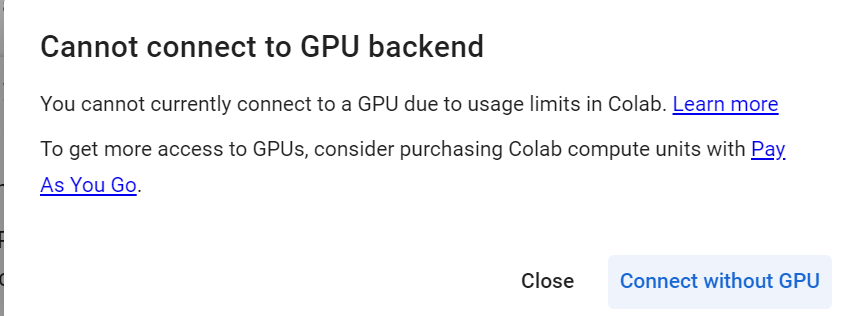

## **Installing and Importing Necessary Libraries**

In [101]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [102]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to compute distances
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

# importing the PyTorch Deep Learning library
import torch

# to import the model
from sentence_transformers import SentenceTransformer

# to cluster the data
from sklearn.cluster import KMeans

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# to import Word2Vec
from gensim.models import Word2Vec

# to split data into train and test sets
from sklearn.model_selection import train_test_split

# to build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# To tune different models
from sklearn.model_selection import GridSearchCV

# to avoid displaying unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading the dataset**

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
news = pd.read_csv("/content/drive/MyDrive/AI&ML/Transformer /stock_news.csv")

In [105]:
# creating a copy of the data
data = news.copy()

## **Data Overview**

In [106]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


In [107]:
data.shape

(349, 8)

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [109]:
data.describe()

,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000


In [110]:
data.Label.value_counts()

,count
Label,
0,170
-1,99
1,80


### **Check Duplicates** ###

In [111]:
# checking for duplicate values
data.duplicated().sum()

0

## **Exploratory Data Analysis**

In [112]:
# Function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [113]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [114]:
# Calculate the length of the text in the 'News' column
data['News_Length'] = data['News'].apply(len)

In [115]:
data['Date'] = pd.to_datetime(data['Date'])

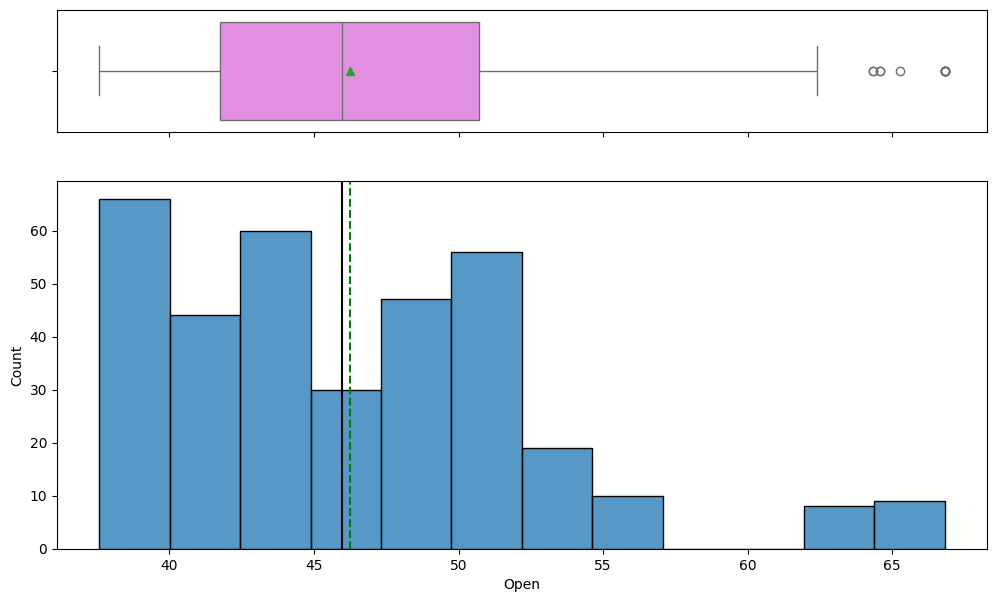

In [116]:
histogram_boxplot(data, "Open")

**Observation**


1.   There are few outliers which makes the distribution right skewed.



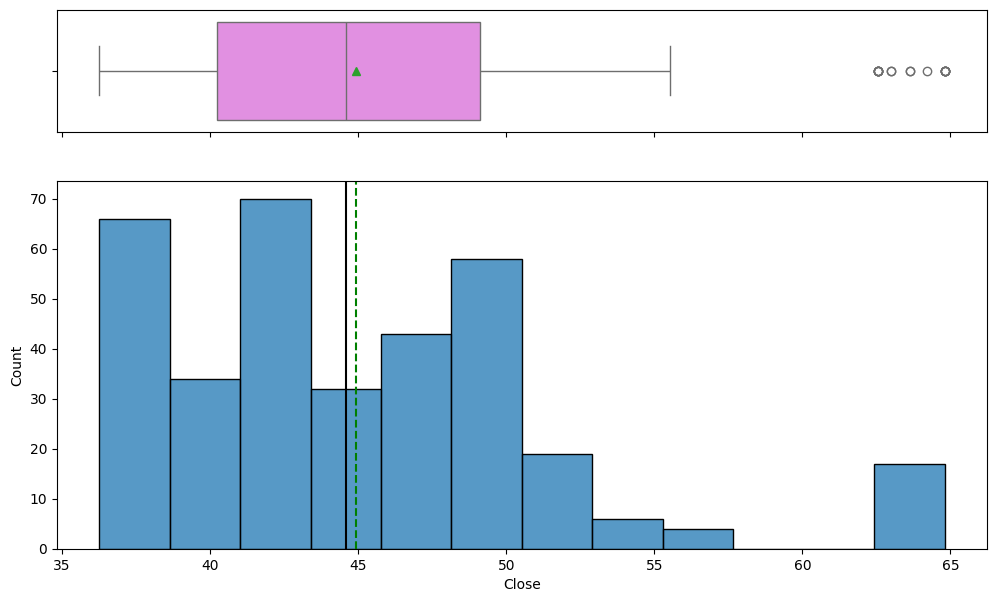

In [117]:
histogram_boxplot(data, "Close")

**Observation**

1.   Close stock price has normal distribution with few outliers.



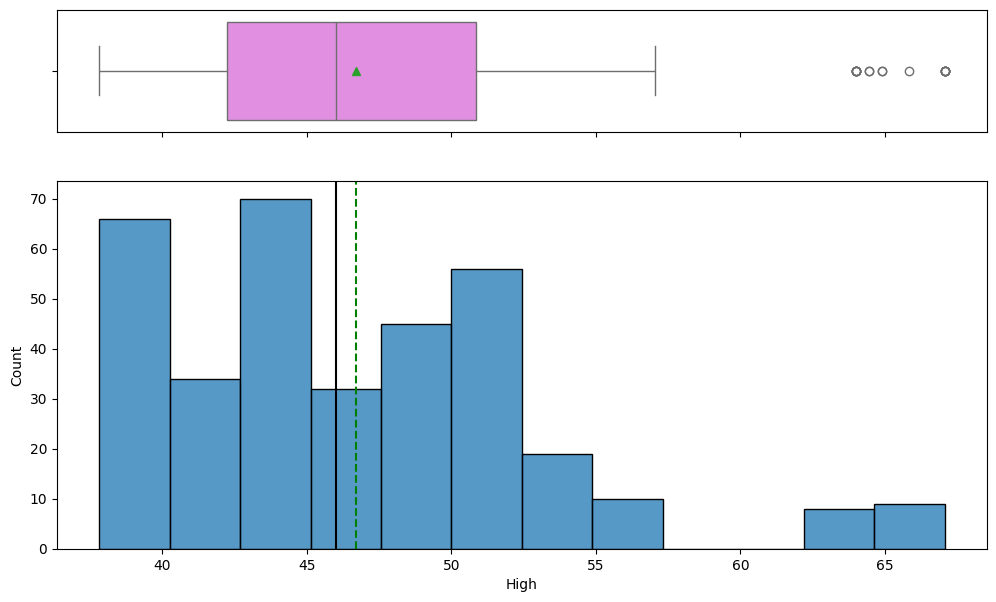

In [118]:
histogram_boxplot(data, "High")

**Observation**

1.   High stock price has normal distribution with few outliers.



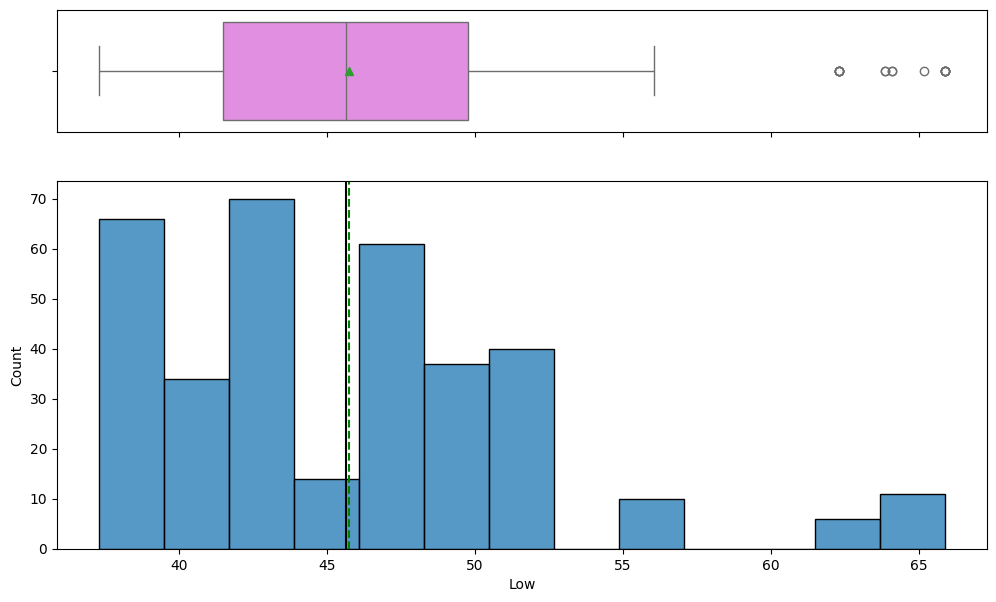

In [119]:
histogram_boxplot(data, "Low")

**Observation**

1.   Low stock price has normal distribution with few outliers.



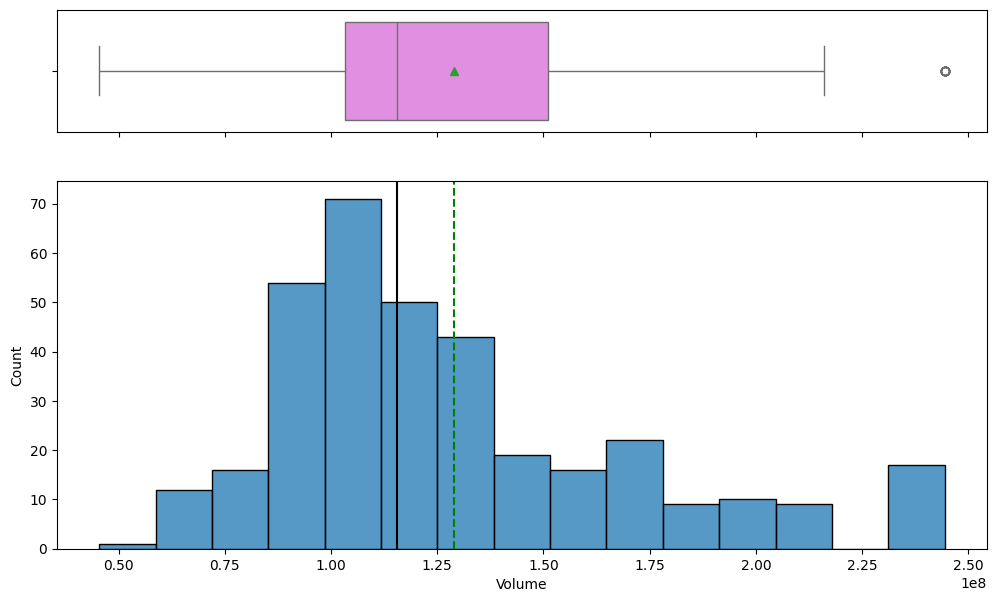

In [120]:
histogram_boxplot(data, "Volume")

**Observation**

1.   Volume stock price has normal distribution.



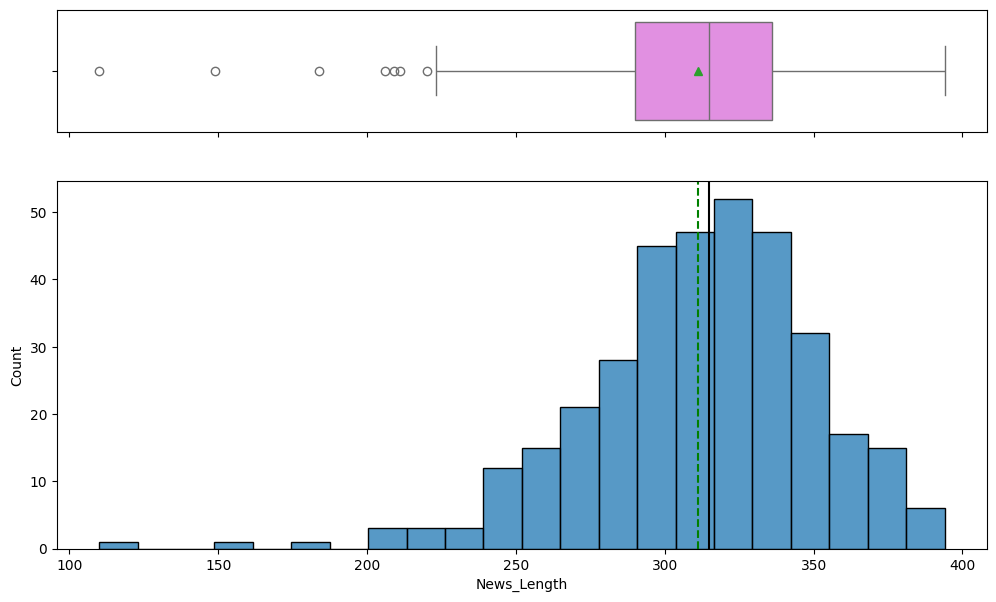

In [121]:
histogram_boxplot(data, "News_Length")

**Observation**

1.   Mean and Median newslength is around 320 chars.
2.   Data is left skwed because of few outliers with less new length.



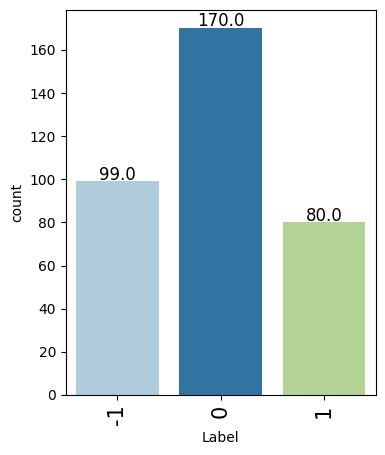

In [122]:
labeled_barplot(data, 'Label')

**Observation**

1.   Neutral news are almost sum of both Positive and Negative news combined.



**Open, High, Low, Close: These stock price variables have similar distributions, with the majority of the values clustered around certain price ranges, indicating consistency in stock behavior.**

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

In [123]:
numerical_vars = ['Open', 'High', 'Low', 'Close', 'Volume', 'Label']

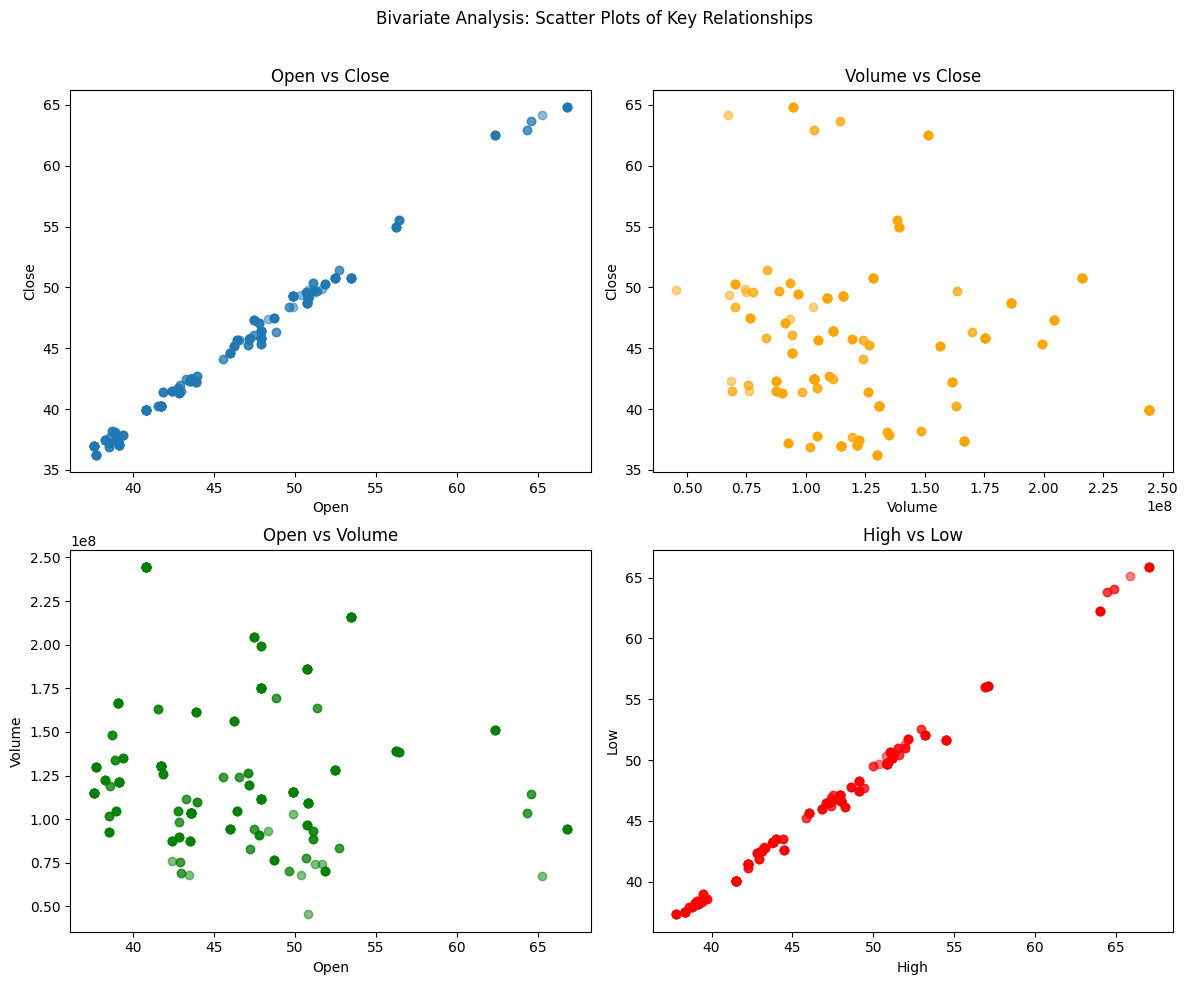

In [124]:
# Scatter plots for bivariate relationships between key variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Bivariate Analysis: Scatter Plots of Key Relationships')

# Open vs Close
axes[0, 0].scatter(data['Open'], data['Close'], alpha=0.5)
axes[0, 0].set_title('Open vs Close')
axes[0, 0].set_xlabel('Open')
axes[0, 0].set_ylabel('Close')

# Volume vs Close
axes[0, 1].scatter(data['Volume'], data['Close'], alpha=0.5, color='orange')
axes[0, 1].set_title('Volume vs Close')
axes[0, 1].set_xlabel('Volume')
axes[0, 1].set_ylabel('Close')

# Open vs Volume
axes[1, 0].scatter(data['Open'], data['Volume'], alpha=0.5, color='green')
axes[1, 0].set_title('Open vs Volume')
axes[1, 0].set_xlabel('Open')
axes[1, 0].set_ylabel('Volume')

# High vs Low
axes[1, 1].scatter(data['High'], data['Low'], alpha=0.5, color='red')
axes[1, 1].set_title('High vs Low')
axes[1, 1].set_xlabel('High')
axes[1, 1].set_ylabel('Low')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


**Observation**

The scatter plots reveal the following insights:

1. Open vs Close: There is a strong linear relationship between the opening and closing prices, suggesting that stocks tend to close near their opening values on most days.
2. Volume vs Close: There doesn't seem to be a strong visible relationship between trading volume and closing prices. The wide spread indicates that other factors influence price changes more than volume alone.
3. Open vs Volume: Similar to the previous observation, volume doesn't show a clear pattern when compared with the opening price.
4. High vs Low: The strong linear relationship between the highest and lowest prices is expected, as these are different points of the stock's range within a single day.
5. These observations align with typical stock market behavior, where prices tend to be closely related to each other, but trading volume does not always directly influence price changes.

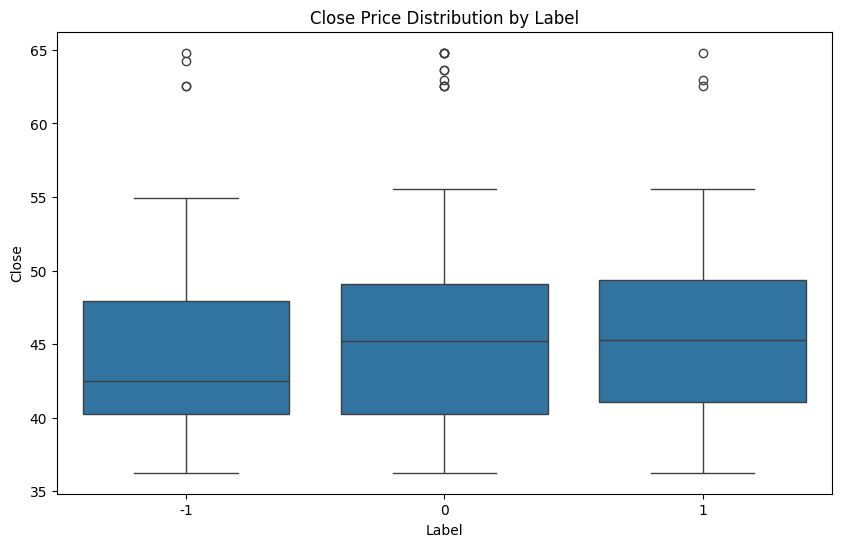

In [125]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Close', data=data)
plt.title('Close Price Distribution by Label')
plt.show()

**Observation**

1.   The close stock price is high when the news is postive or neutral.
2.   THe Median value of close stock price 42 for negative news compared to 45 for neutral and positive news.



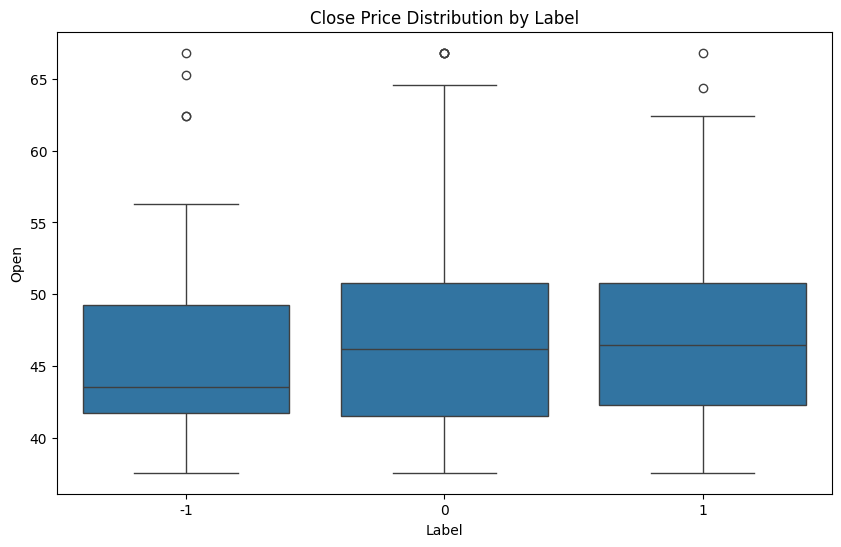

In [126]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Open', data=data)
plt.title('Close Price Distribution by Label')
plt.show()

**Observation**

1.   The open stock price is high when the news is postive or neutral.
2.   THe Median value of open stock price 44 for negative news compared to 47 for neutral and positive news.



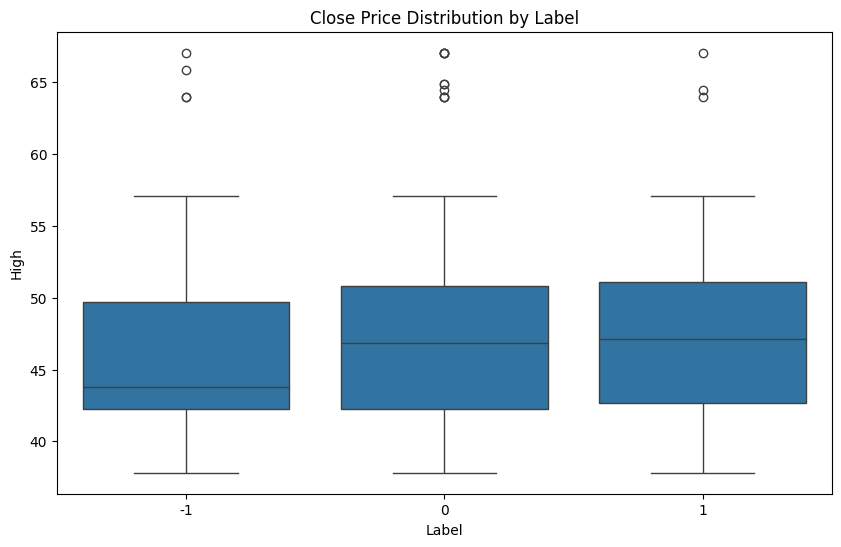

In [127]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='High', data=data)
plt.title('Close Price Distribution by Label')
plt.show()

**Observation**

1.   The Stock price is high when the news is postive or neutral.
2.   THe Median value of highest stock price 44 for negative news compared to 47 for neutral and positive news.



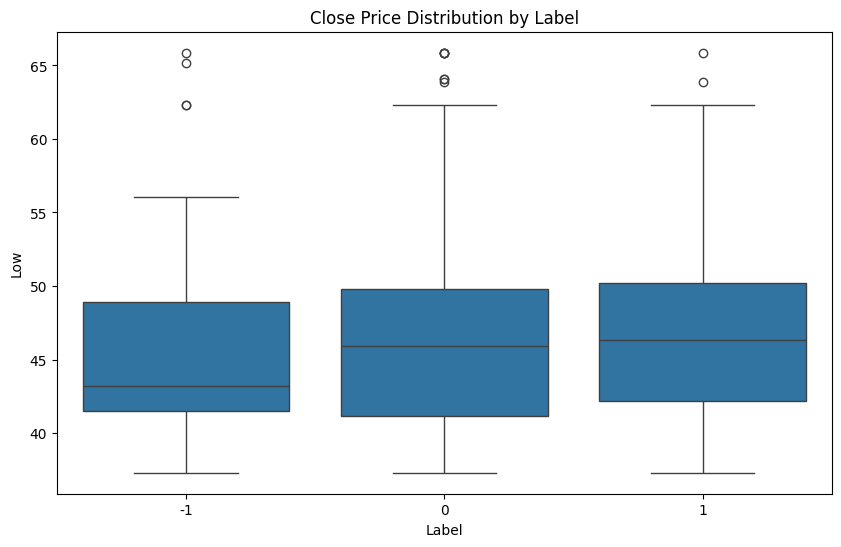

In [128]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Low', data=data)
plt.title('Close Price Distribution by Label')
plt.show()

**Observation**

1.   The Stock price is Low when the news is postive or neutral.
2.   THe Median value of Lowest stock price 44 for negative news compared to 47 for neutral and positive news.



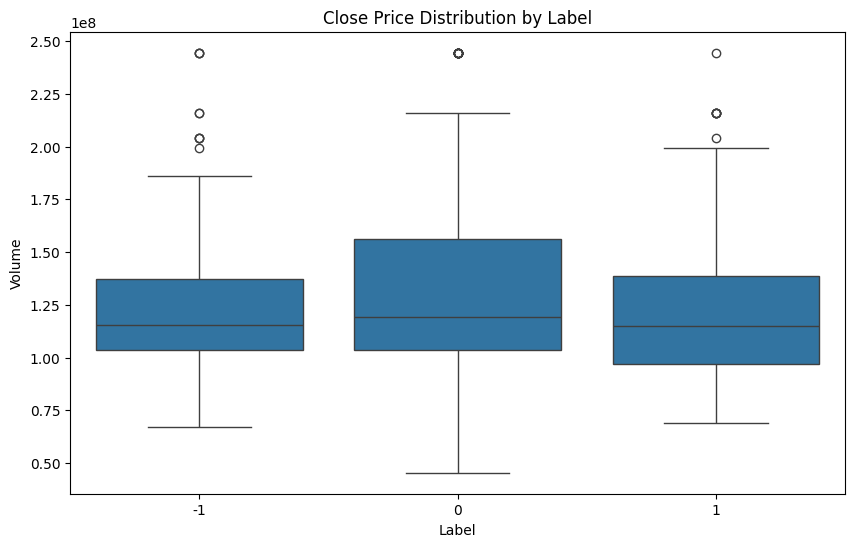

In [129]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Volume', data=data)
plt.title('Close Price Distribution by Label')
plt.show()

**Observation**

1.   The median trading volume is relatively similar for both positive and negative news, with no significant difference in volume distributions.



In [130]:
# Group by date and calculate summary statistics
daily_summary = data.groupby('Date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

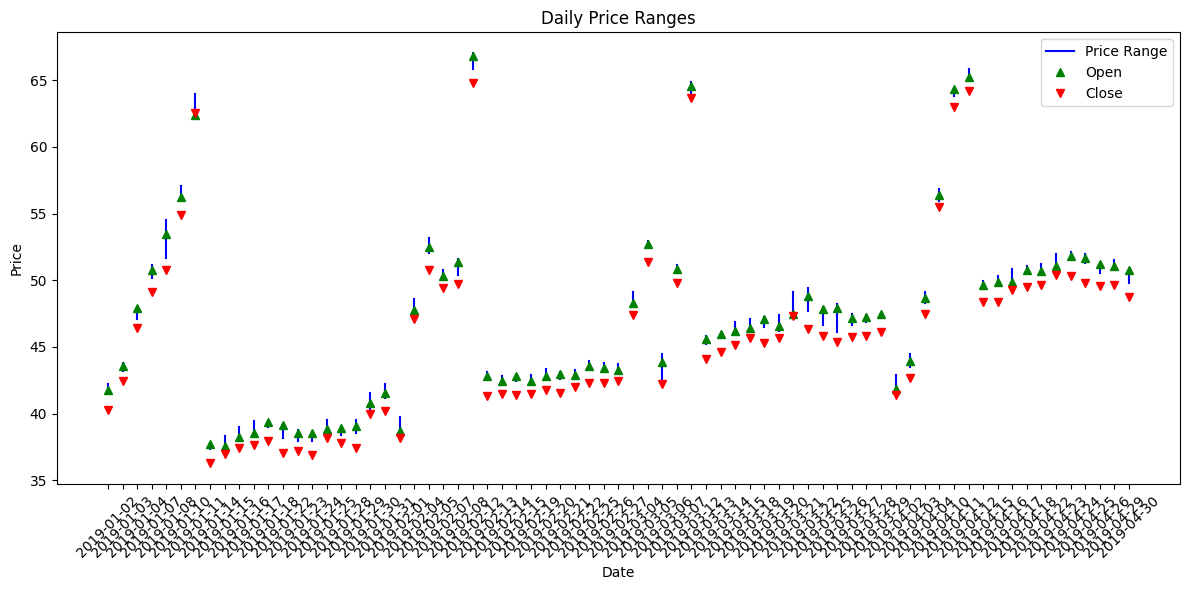

In [131]:
plt.figure(figsize=(12, 6))
for i, (date, row) in enumerate(daily_summary.iterrows()):
    plt.plot([i, i], [row['Low'], row['High']], 'b-')
    plt.plot([i], [row['Open']], 'g^')
    plt.plot([i], [row['Close']], 'rv')

plt.title('Daily Price Ranges')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(range(len(daily_summary)), daily_summary.index.strftime('%Y-%m-%d'), rotation=45)
plt.legend(['Price Range', 'Open', 'Close'])
plt.tight_layout()
plt.show()

**Observation**

1.   Price Stability: For most days, the difference between the high and low prices is relatively small, indicating that the stock doesn't experience extreme volatility within a single day.
2. Opening vs. Closing Prices: On many days, the closing price is lower than the opening price, especially toward the start of the chart, which aligns with the observation that there were more days with a price decline (as indicated by the label distribution).
3. Consistent Patterns: The majority of days exhibit a clear pattern where the opening and closing prices fall within a narrow range of the high-low prices. There are only a few days where significant gaps exist between the opening or closing prices and the extremes (high or low), suggesting stability in the stock's performance.

4. Few Large Fluctuations: Some days show significant vertical blue lines (wider high-low range), indicating higher price volatility on those days. However, these days are the exception rather than the rule.



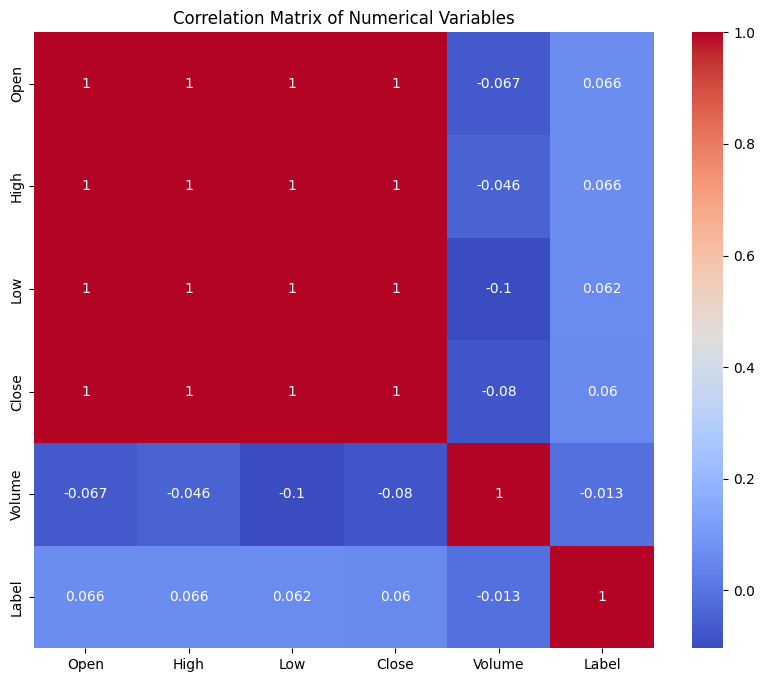

In [132]:
correlation_matrix = data[numerical_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

**Observation**

1.  Stock Prices (Open, High, Low, Close): These variables are highly correlated with each other, as expected, since they all represent different points of the stock's performance on the same day.
2.  Volume: Trading volume shows a weak negative correlation with stock prices, indicating that higher volumes do not necessarily lead to higher or lower prices.
3. Label: The label, which represents the movement direction of the stock price, has a very weak correlation with other variables, meaning that price movements aren't directly tied to any single variable like the open or close price.



## **Data Preprocessing**

### Removing special characters from the text

In [133]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [134]:
# Applying the function to remove special characters
data['cleaned_text'] = data['News'].apply(remove_special_characters)

In [135]:
# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",The tech sector experienced a significant decline in the aftermarket following Apple s Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo and TSMC saw their stocks drop in response to Apple s downward revision of its revenue expectations for the quarter previously announced in January
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",Apple lowered its fiscal Q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iPhone sales The announcement caused a significant drop in Apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as Nasdaq 10
2,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",Apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in China and fewer iPhone upgrades CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks Apple s shares fell 8 5 in post market trading while Asian suppliers like Hon
3,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",This news article reports that yields on long dated U S Treasury securities hit their lowest levels in nearly a year on January 2 2019 due to concerns about the health of the global economy following weak economic data from China and Europe as well as the partial U S government shutdown Apple


### Lowercasing

In [136]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iphone sales the announcement caused a significant drop in apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10
2,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in china and fewer iphone upgrades ceo tim cook also mentioned constrained sales of airpods and macbooks apple s shares fell 8 5 in post market trading while asian suppliers like hon
3,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",this news article reports that yields on long dated u s treasury securities hit their lowest levels in nearly a year on january 2 2019 due to concerns about the health of the global economy following weak economic data from china and europe as well as the partial u s government shutdown apple


### Removing extra whitespace

In [137]:
# removing extra whitespaces from the text
data['cleaned_text'] = data['cleaned_text'].str.strip()

# checking a couple of instances of cleaned data
data.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iphone sales the announcement caused a significant drop in apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10
2,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in china and fewer iphone upgrades ceo tim cook also mentioned constrained sales of airpods and macbooks apple s shares fell 8 5 in post market trading while asian suppliers like hon
3,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",this news article reports that yields on long dated u s treasury securities hit their lowest levels in nearly a year on january 2 2019 due to concerns about the health of the global economy following weak economic data from china and europe as well as the partial u s government shutdown apple


### Removing stopwords

* The idea with stop word removal is to **exclude words that appear frequently throughout** all the documents in the corpus.
* Pronouns and articles are typically categorized as stop words.
* The `NLTK` library has an in-built list of stop words and it can utilize that list to remove the stop words from a dataset.

In [138]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [139]:
# Applying the function to remove stop words using the NLTK library
data['cleaned_text_without_stopwords'] = data['cleaned_text'].apply(remove_stopwords)

# checking a couple of instances of cleaned data
data.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january,tech sector experienced significant decline aftermarket following apple q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple downward revision revenue expectations quarter previously announced january
1,apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iphone sales the announcement caused a significant drop in apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10,apple lowered fiscal q1 revenue guidance 84 billion earlier estimates 89 93 billion due weaker expected iphone sales announcement caused significant drop apple stock price negatively impacted related suppliers leading broader market declines tech indices nasdaq 10
2,apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in china and fewer iphone upgrades ceo tim cook also mentioned constrained sales of airpods and macbooks apple s shares fell 8 5 in post market trading while asian suppliers like hon,apple cut fiscal first quarter revenue forecast 89 93 billion 84 billion due weaker demand china fewer iphone upgrades ceo tim cook also mentioned constrained sales airpods macbooks apple shares fell 8 5 post market trading asian suppliers like hon
3,this news article reports that yields on long dated u s treasury securities hit their lowest levels in nearly a year on january 2 2019 due to concerns about the health of the global economy following weak economic data from china and europe as well as the partial u s government shutdown apple,news article reports yields long dated u treasury securities hit lowest levels nearly year january 2 2019 due concerns health global economy following weak economic data china europe well partial u government shutdown apple


### Stemming

Stemming is a language processing method that chops off word endings to find the root or base form of words.

For example,

- Original Word: Jumping, Stemmed Word: Jump
- Original Word: Running, Stemmed Word: Run

The Porter Stemmer is one of the widely-used algorithms for stemming, and it shorten words to their root form by removing suffixes.

In [140]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [141]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [142]:
# Applying the function to perform stemming
data['final_cleaned_text'] = data['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

# checking a couple of instances of cleaned data
data.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,tech sector experienced significant decline aftermarket following apple q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple downward revision revenue expectations quarter previously announced january,tech sector experienc signific declin aftermarket follow appl q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl downward revis revenu expect quarter previous announc januari
1,apple lowered fiscal q1 revenue guidance 84 billion earlier estimates 89 93 billion due weaker expected iphone sales announcement caused significant drop apple stock price negatively impacted related suppliers leading broader market declines tech indices nasdaq 10,appl lower fiscal q1 revenu guidanc 84 billion earlier estim 89 93 billion due weaker expect iphon sale announc caus signific drop appl stock price neg impact relat supplier lead broader market declin tech indic nasdaq 10
2,apple cut fiscal first quarter revenue forecast 89 93 billion 84 billion due weaker demand china fewer iphone upgrades ceo tim cook also mentioned constrained sales airpods macbooks apple shares fell 8 5 post market trading asian suppliers like hon,appl cut fiscal first quarter revenu forecast 89 93 billion 84 billion due weaker demand china fewer iphon upgrad ceo tim cook also mention constrain sale airpod macbook appl share fell 8 5 post market trade asian supplier like hon


## **Word Embeddings**

### Word2Vec

In [143]:
# creating a list of all words in our data
words_list = [item.split(" ") for item in data['final_cleaned_text'].values]

# Checking the words from the first five reviews
words_list[0:5]

[['tech',
  'sector',
  'experienc',
  'signific',
  'declin',
  'aftermarket',
  'follow',
  'appl',
  'q1',
  'revenu',
  'warn',
  'notabl',
  'supplier',
  'includ',
  'skywork',
  'broadcom',
  'lumentum',
  'qorvo',
  'tsmc',
  'saw',
  'stock',
  'drop',
  'respons',
  'appl',
  'downward',
  'revis',
  'revenu',
  'expect',
  'quarter',
  'previous',
  'announc',
  'januari'],
 ['appl',
  'lower',
  'fiscal',
  'q1',
  'revenu',
  'guidanc',
  '84',
  'billion',
  'earlier',
  'estim',
  '89',
  '93',
  'billion',
  'due',
  'weaker',
  'expect',
  'iphon',
  'sale',
  'announc',
  'caus',
  'signific',
  'drop',
  'appl',
  'stock',
  'price',
  'neg',
  'impact',
  'relat',
  'supplier',
  'lead',
  'broader',
  'market',
  'declin',
  'tech',
  'indic',
  'nasdaq',
  '10'],
 ['appl',
  'cut',
  'fiscal',
  'first',
  'quarter',
  'revenu',
  'forecast',
  '89',
  '93',
  'billion',
  '84',
  'billion',
  'due',
  'weaker',
  'demand',
  'china',
  'fewer',
  'iphon',
  'upgr

In [144]:
# creating an instance of Word2Vec
model_W2V = Word2Vec(words_list, min_count = 1, workers = 6)

In [145]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


Let's check out a few word embeddings using the trained model.

In [146]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-0.00939042,  0.02728893, -0.00179864,  0.00085851,  0.01197089,
       -0.03147813,  0.00583432,  0.05673728, -0.0211053 , -0.00580397,
       -0.01649901, -0.03131568,  0.00751066,  0.01000486,  0.01745957,
       -0.02391381,  0.00593773, -0.0135042 , -0.00779802, -0.0490499 ,
        0.00426563,  0.00732018,  0.00859976, -0.01935172,  0.00804449,
       -0.0092931 , -0.00915663, -0.01206032, -0.02436675,  0.00762249,
        0.02302203, -0.00104659, -0.00050734, -0.01894653, -0.01395254,
        0.0240732 ,  0.00433779, -0.01643676, -0.01429695, -0.0454313 ,
       -0.00303172, -0.02230789, -0.00726029,  0.00670939,  0.02387281,
        0.00315632, -0.01480374, -0.00865937,  0.00608062,  0.01413491,
        0.01615038, -0.02581942, -0.01541378, -0.0076328 , -0.03019814,
        0.00995614,  0.01557266, -0.00954835, -0.03199108,  0.00204231,
        0.01088261,  0.00797739,  0.00691616, -0.00419195, -0.03841973,
        0.02755509,  0.01372718,  0.02015364, -0.03778822,  0.03

In [147]:
# Checking top 5 similar words to the word 'performance'
similar = model_W2V.wv.similar_by_word('tech', topn=5)
print(similar)

[('appl', 0.9080695509910583), ('year', 0.8980268836021423), ('due', 0.8899613618850708), ('market', 0.8871337175369263), ('compani', 0.8870055675506592)]


In [148]:
# Checking top 5 similar words to the word 'book'
similar = model_W2V.wv.similar_by_word('book', topn=5)
print(similar)

[('like', 0.42107847332954407), ('92', 0.398386687040329), ('spotifi', 0.39536553621292114), ('investor', 0.379536896944046), ('weak', 0.3726256489753723)]


In [149]:
# Dictionary with key as words and the value as the embedding vector.
words = model_W2V.wv.key_to_index

In [150]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(words[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [151]:
# creating a dataframe of the vectorized documents
vec_size = 100
df_word2vec = pd.DataFrame(data['final_cleaned_text'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_word2vec

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,...,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250
1,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,...,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919
2,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,...,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000
3,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,...,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588
4,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,...,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,...,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519
345,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,...,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857
346,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,...,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649
347,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,...,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000


### GloVe

In [152]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/AI&ML/Transformer /glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [153]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(model.index_to_key))

Length of the vocabulary is 400000


In [154]:
# Checking the word embedding of a random word
word = "tech"
model[word]

array([ 1.7843e-03,  6.8545e-01,  5.6025e-01, -8.6622e-01, -2.9546e-01,
       -1.0384e+00,  3.0974e-01, -6.2464e-01, -6.2188e-02,  2.8650e-01,
        8.0992e-02, -8.8250e-01, -2.3466e-01, -3.8845e-01, -8.3436e-02,
        1.2889e-01,  5.5155e-01,  3.5414e-01, -1.1191e-01,  3.4009e-01,
       -5.1375e-02, -1.3438e-01, -1.4942e-01,  4.9742e-01, -6.8934e-03,
       -7.3037e-02, -5.8057e-02, -9.7514e-02, -7.8936e-01, -3.0539e-02,
       -6.8881e-01,  3.4915e-01, -8.6009e-02,  1.9135e-01, -3.8473e-01,
       -7.1563e-01, -6.6354e-01, -1.2526e-01, -5.7488e-02, -3.4466e-02,
       -2.2225e-01, -1.0319e+00, -2.5942e-01, -1.0450e-01, -5.4620e-01,
       -2.7348e-01,  2.5347e-01,  1.2270e+00,  9.6006e-01, -1.0778e+00,
       -7.7286e-01, -1.2136e-01, -3.5255e-01, -2.8355e-01,  4.5948e-02,
       -1.4572e+00,  3.4030e-01, -4.2073e-02,  1.8725e+00, -2.5885e-02,
       -7.9068e-01, -2.3935e-03, -2.6566e-01,  1.4091e-01, -3.8906e-01,
        9.4408e-02,  9.0978e-01,  3.6179e-01,  1.7851e-01,  1.30

In [155]:
#Returning the top 5 similar words.
result = model.most_similar("tech", topn=5)
print(result)

[('technology', 0.7489413022994995), ('electronics', 0.6403473019599915), ('computer', 0.6364049911499023), ('chip', 0.6102194786071777), ('big', 0.5954535007476807)]


In [156]:
#Returning the top 5 similar words.
result = model.most_similar("book", topn=5)
print(result)

[('books', 0.847648561000824), ('novel', 0.8181166648864746), ('published', 0.8023924231529236), ('story', 0.7941390872001648), ('author', 0.7937875390052795)]


In [157]:
#List of words in the vocabulary
words = model.index_to_key

In [158]:
#Dictionary with key as the word and the value as the corresponding embedding vector.
word_vector_dict = dict(zip(model.index_to_key,list(model.vectors)))

In [159]:
#Defining the dimension of the embedded vector.
vec_size=100

In [160]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [161]:
# creating a dataframe of the vectorized documents
df_glove = pd.DataFrame(data['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,0.021671,0.096785,-0.047464,-0.066726,-0.215078,-0.603108,-0.089054,-0.001979,0.114239,-0.132121,...,-0.016118,0.282037,-0.146394,-0.217284,-0.137730,0.162514,0.208869,0.056668,0.186156,-0.025540
1,0.171825,0.341351,0.234650,-0.042054,-0.082840,-0.600302,-0.060674,-0.101788,-0.159387,0.023604,...,0.001762,0.271578,-0.190244,-0.136070,-0.442046,0.225178,0.175980,-0.036701,0.410090,-0.159631
2,0.010512,0.270341,0.301482,-0.087113,0.075485,-0.476547,-0.039534,-0.014161,-0.123561,-0.054536,...,0.113562,0.199301,-0.095302,-0.220799,-0.559601,0.130351,0.039756,-0.088995,0.484577,-0.204774
3,-0.147407,0.226970,0.377158,0.184659,-0.110523,-0.447424,-0.103314,0.033698,-0.021951,-0.041905,...,0.031969,0.314802,-0.276519,0.034750,-0.347012,0.131816,0.201519,-0.220721,0.328415,-0.101222
4,0.040798,0.198312,0.071460,0.037332,-0.098294,-0.407203,-0.078844,-0.102327,-0.132380,-0.031861,...,0.041134,0.188611,-0.051261,-0.364269,-0.216124,0.242409,0.243280,-0.071136,0.173813,-0.131392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,-0.133417,0.058861,0.415255,-0.291097,0.051498,0.079182,0.057609,0.127537,-0.074177,-0.070428,...,0.306373,-0.166262,0.083386,-0.120771,-0.347820,0.049615,-0.054991,-0.299478,0.437251,0.188692
345,0.159967,0.246612,0.288849,0.093632,0.043483,-0.284527,-0.167188,-0.049947,-0.246812,-0.088806,...,0.042174,0.246746,-0.054319,-0.047361,-0.572373,0.368322,0.077437,0.020181,0.441181,0.015956
346,0.043433,0.127144,0.151791,-0.053902,-0.067352,-0.187623,-0.020754,0.138385,-0.354622,-0.084654,...,-0.066027,0.240859,-0.119884,-0.026659,-0.428011,0.054745,-0.025141,-0.129436,0.258558,-0.027775
347,-0.098248,0.090049,0.181622,-0.028409,-0.128997,-0.497643,-0.247336,-0.034014,-0.103773,-0.195073,...,0.012848,0.070933,-0.053851,-0.265540,-0.415342,0.111974,0.295720,-0.207213,0.378713,0.026234


### Scentence Transformer Embdeddings.

We'll be using the **all-MiniLM-L6-v2** model here.

💡 The **all-MiniLM-L6-v2** model is an all-round (**all**) model trained on a large and diverse dataset of over 1 billion training samples and generates state-of-the-art sentence embeddings of 384 dimensions.

📊  It is a language model (**LM**) that has 6 transformer encoder layers (**L6**) and is a smaller model (**Mini**) trained to mimic the performance of a larger model (BERT).

🛠️ Potential use-cases include text classification, sentiment analysis, and semantic search.

In [162]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [163]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [164]:
# encoding the dataset
embedding_matrix = model.encode(data['News'], show_progress_bar=True, device=device)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [165]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(349, 384)

- Each news article has been converted to a 384-dimensional vector

In [166]:
# printing the embedding vector of the first review in the dataset
embedding_matrix[0]

array([-2.02313159e-03, -3.67734767e-02,  7.73542821e-02,  4.67134863e-02,
        3.25521603e-02,  2.10235314e-03,  4.32834662e-02,  3.95345129e-02,
        5.82279675e-02,  8.87510274e-03,  7.09636360e-02,  4.99076843e-02,
        6.46608472e-02, -4.97969892e-03, -1.30518824e-02, -2.98355483e-02,
       -8.91323388e-03, -7.82000571e-02, -2.17109602e-02, -5.24823181e-02,
       -5.14276326e-02, -3.30719724e-02, -3.32051739e-02,  4.18126024e-02,
        7.99547434e-02,  1.54092591e-02, -2.15781815e-02,  5.19439541e-02,
       -4.65799198e-02, -3.71372215e-02, -1.04225568e-01,  9.86079201e-02,
        5.21786660e-02,  3.46579105e-02,  1.48810120e-02, -4.47349763e-03,
        5.70117570e-02, -2.41722949e-02,  2.14048848e-02, -6.52144775e-02,
       -3.30644958e-02,  1.61960311e-02, -6.63141757e-02,  4.39942963e-02,
        3.82153057e-02, -4.86519225e-02,  1.62651595e-02, -4.02664989e-02,
       -3.34572373e-03,  3.20955552e-02, -3.91194923e-03, -1.26830228e-02,
        4.49699089e-02,  

#### Splitting the dataset

In [167]:
# Creating dependent and independent variables
X_word2vec = df_word2vec.copy()
X_glove = df_glove.copy()
X_tranformer = embedding_matrix.copy()
y = data['Label']

In [168]:
def split(X,y):
    # Initial split into training (80%) and testing (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Further split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [169]:
#Splitting the dataset.
X_train_word2vec,X_valid_word2vec,X_test_word2vec,y_train_word2vec,y_valid_word2vec,y_test_word2vec=split(X_word2vec,y)
X_train_glove,X_valid_glove,X_test_glove,y_train_glove,y_valid_glove,y_test_glove=split(X_glove,y)
X_train_tranformer,X_valid_tranformer,X_test_tranformer,y_train_tranformer,y_valid_tranformer,y_test_tranformer=split(X_tranformer,y)

In [170]:
print(X_train_tranformer.shape, X_test_tranformer.shape, X_valid_tranformer.shape)

(279, 384) (35, 384) (35, 384)


In [171]:
print(X_train_glove.shape, X_test_glove.shape, X_valid_glove.shape)

(279, 100) (35, 100) (35, 100)


## **Sentiment Analysis**

**Model and Metric selection**

1. For the doing the sentiment analysis I am planning to use Random Forest.
2. For the metric of choice, I will go with F1 Score because the target variable is multi class and more over the dataset is imbalanced.

In [172]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Random Forest Model (default with Word2Vec)

In [173]:
# Building the model
rf_w2v = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_w2v.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(random_state=42)

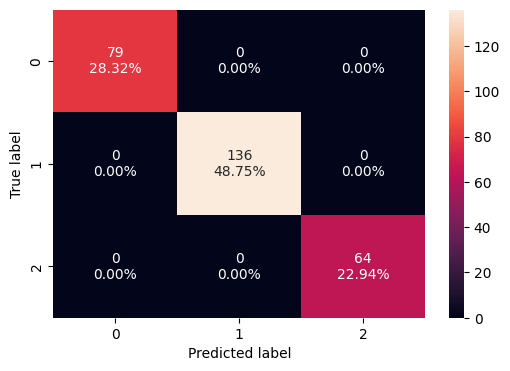

In [174]:
confusion_matrix_sklearn(rf_w2v, X_train_word2vec, y_train_word2vec)

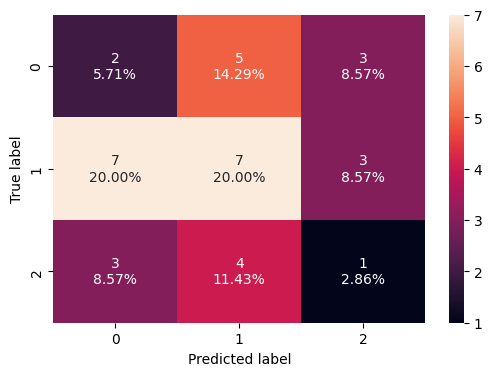

In [175]:
confusion_matrix_sklearn(rf_w2v, X_valid_word2vec, y_valid_word2vec)

In [176]:
# Predicting on train data
y_pred_train_word2vec = rf_w2v.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_word2vec = rf_w2v.predict(X_valid_word2vec)

In [177]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [178]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec))

              precision    recall  f1-score   support

          -1       0.17      0.20      0.18        10
           0       0.44      0.41      0.42        17
           1       0.14      0.12      0.13         8

    accuracy                           0.29        35
   macro avg       0.25      0.25      0.25        35
weighted avg       0.29      0.29      0.29        35



### Random Forest Model (default with GloVe)

In [179]:
# Building the model
rf_glove = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_glove.fit(X_train_glove, y_train_glove)

RandomForestClassifier(random_state=42)

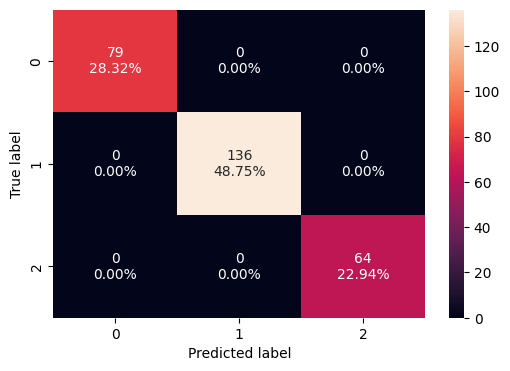

In [180]:
confusion_matrix_sklearn(rf_glove, X_train_glove, y_train_glove)

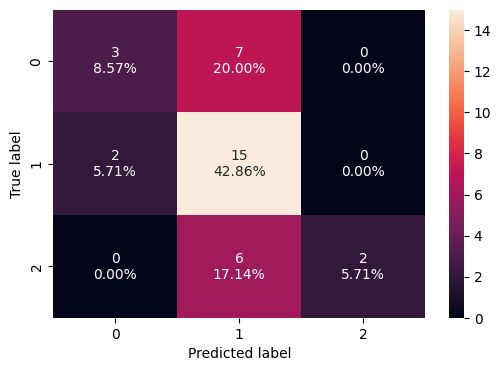

In [181]:
confusion_matrix_sklearn(rf_glove, X_valid_glove, y_valid_glove)

In [182]:
# Predicting on train data
y_pred_train_glove = rf_glove.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove = rf_glove.predict(X_valid_glove)

In [183]:
print(classification_report(y_train_glove, y_pred_train_glove))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [184]:
print(classification_report(y_valid_glove, y_pred_valid_glove))

              precision    recall  f1-score   support

          -1       0.60      0.30      0.40        10
           0       0.54      0.88      0.67        17
           1       1.00      0.25      0.40         8

    accuracy                           0.57        35
   macro avg       0.71      0.48      0.49        35
weighted avg       0.66      0.57      0.53        35



### Random Forest Model (default with Transformer Embeddings)

In [185]:
# Building the model
rf_transformer = RandomForestClassifier(random_state = 42)

# Fitting on train data
rf_transformer.fit(X_train_tranformer, y_train_tranformer)

RandomForestClassifier(random_state=42)

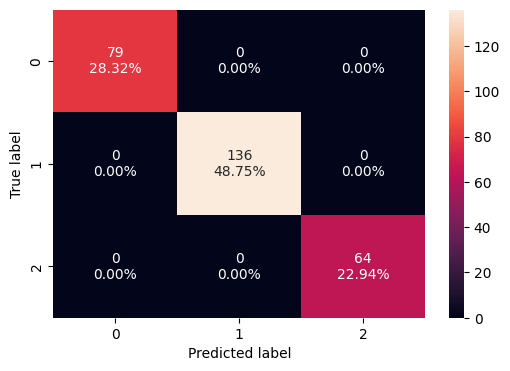

In [186]:
confusion_matrix_sklearn(rf_transformer, X_train_tranformer, y_train_tranformer)

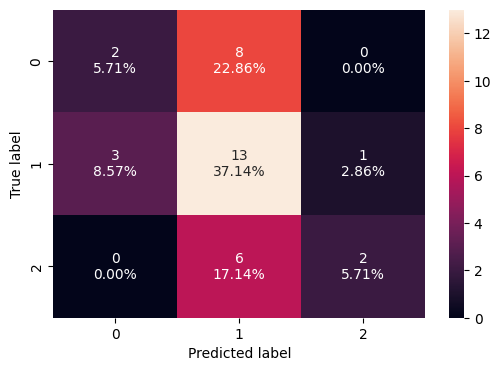

In [187]:
confusion_matrix_sklearn(rf_transformer, X_valid_tranformer, y_valid_tranformer)

In [188]:
# Predicting on train data
y_pred_train_transformer = rf_transformer.predict(X_train_tranformer)

# Predicting on validation data
y_pred_valid_transformer = rf_transformer.predict(X_valid_tranformer)

In [189]:
print(classification_report(y_train_tranformer, y_pred_train_transformer))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        79
           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [190]:
print(classification_report(y_valid_tranformer, y_pred_valid_transformer))

              precision    recall  f1-score   support

          -1       0.40      0.20      0.27        10
           0       0.48      0.76      0.59        17
           1       0.67      0.25      0.36         8

    accuracy                           0.49        35
   macro avg       0.52      0.40      0.41        35
weighted avg       0.50      0.49      0.45        35



### Random Forest Model (Hyperparam tuning with Word2Vec)

In [191]:
# Choose the type of classifier
rf_w2v_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_w2v_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_word2vec, y_train_word2vec)

In [192]:
# Creating a new model with the best combination of parameters
rf_w2v_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_w2v_tuned.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=7, n_estimators=30, random_state=42)

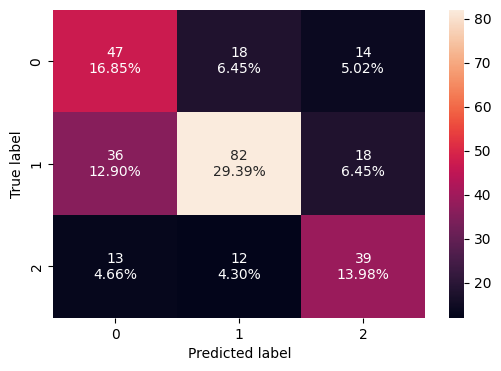

In [193]:
confusion_matrix_sklearn(rf_w2v_tuned, X_train_word2vec, y_train_word2vec)

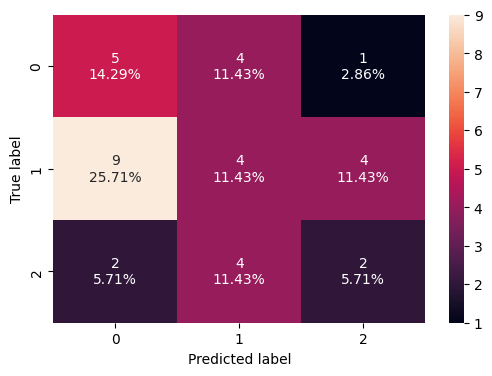

In [194]:
confusion_matrix_sklearn(rf_w2v_tuned, X_valid_word2vec, y_valid_word2vec)

In [195]:
# Predicting on train data
y_pred_train_word2vec_tuned = rf_w2v_tuned.predict(X_train_word2vec)

# Predicting on validation data
y_pred_valid_word2vec_tuned = rf_w2v_tuned.predict(X_valid_word2vec)

In [196]:
print(classification_report(y_train_word2vec, y_pred_train_word2vec_tuned))

              precision    recall  f1-score   support

          -1       0.49      0.59      0.54        79
           0       0.73      0.60      0.66       136
           1       0.55      0.61      0.58        64

    accuracy                           0.60       279
   macro avg       0.59      0.60      0.59       279
weighted avg       0.62      0.60      0.61       279



In [197]:
print(classification_report(y_valid_word2vec, y_pred_valid_word2vec_tuned))

              precision    recall  f1-score   support

          -1       0.31      0.50      0.38        10
           0       0.33      0.24      0.28        17
           1       0.29      0.25      0.27         8

    accuracy                           0.31        35
   macro avg       0.31      0.33      0.31        35
weighted avg       0.32      0.31      0.30        35



### Random Forest Model Hyperparam tuning  with GloVe)

In [99]:
# Choose the type of classifier
rf_glove_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_glove_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_glove)

In [100]:
# Creating a new model with the best combination of parameters
rf_glove_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_glove_tuned.fit(X_train_glove, y_train_glove)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=0.7,
                       min_samples_split=5, n_estimators=90, random_state=42)

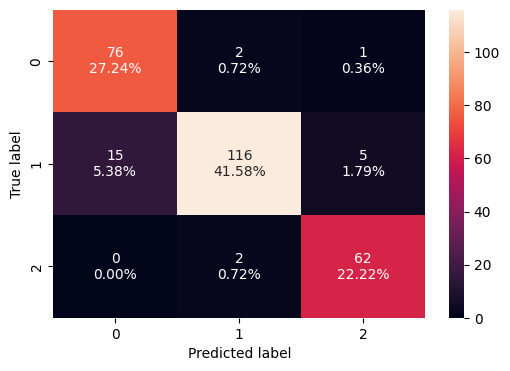

In [198]:
confusion_matrix_sklearn(rf_glove_tuned, X_train_glove, y_train_glove)

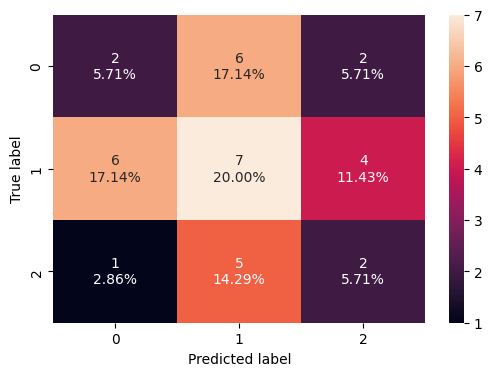

In [199]:
confusion_matrix_sklearn(rf_glove_tuned, X_valid_glove, y_valid_glove)

In [200]:
# Predicting on train data
y_pred_train_glove_tuned = rf_glove_tuned.predict(X_train_glove)

# Predicting on validation data
y_pred_valid_glove_tuned = rf_glove_tuned.predict(X_valid_glove)

In [201]:
print(classification_report(y_train_glove, y_pred_train_glove_tuned))

              precision    recall  f1-score   support

          -1       0.84      0.96      0.89        79
           0       0.97      0.85      0.91       136
           1       0.91      0.97      0.94        64

    accuracy                           0.91       279
   macro avg       0.90      0.93      0.91       279
weighted avg       0.92      0.91      0.91       279



In [202]:
print(classification_report(y_valid_glove, y_pred_valid_glove_tuned))

              precision    recall  f1-score   support

          -1       0.22      0.20      0.21        10
           0       0.39      0.41      0.40        17
           1       0.25      0.25      0.25         8

    accuracy                           0.31        35
   macro avg       0.29      0.29      0.29        35
weighted avg       0.31      0.31      0.31        35



### Random Forest Model (With Class_Weight and with Transformer Embeddings)

In [203]:
# Choose the type of classifier
rf_tf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

# defining the hyperparameter grid for tuning
parameters = {
    "max_depth": list(np.arange(4, 15, 2)),
    "max_features": ["sqrt", 0.5, 0.7],
    "min_samples_split": [5, 6, 7],
    "n_estimators": np.arange(30, 110, 10),
}

# defining the type of scoring used to compare parameter combinations
# we need to specify the mechanism of averaging as we have more than 2 target classes
scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

# running the grid search
grid_obj = GridSearchCV(rf_tf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_tranformer, y_train_tranformer)

In [204]:
# Creating a new model with the best combination of parameters
rf_tf_tuned = grid_obj.best_estimator_

# Fit the new model to the data
rf_tf_tuned.fit(X_train_tranformer, y_train_tranformer)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=7, random_state=42)

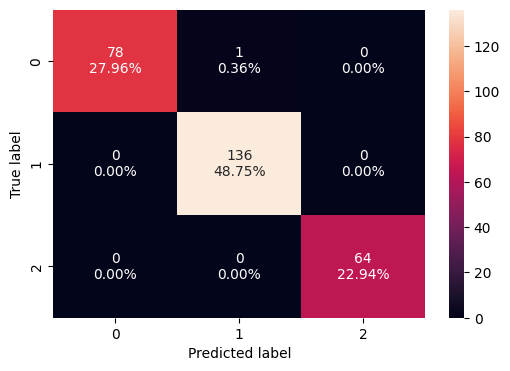

In [205]:
confusion_matrix_sklearn(rf_tf_tuned, X_train_tranformer, y_train_tranformer)

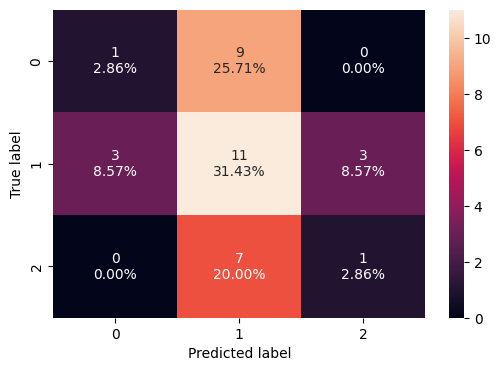

In [206]:
confusion_matrix_sklearn(rf_tf_tuned, X_valid_tranformer, y_valid_tranformer)

In [207]:
# Predicting on train data
y_pred_train_transformer_tuned = rf_tf_tuned.predict(X_train_tranformer)

# Predicting on validation data
y_pred_valid_transformer_tuned = rf_tf_tuned.predict(X_valid_tranformer)

In [208]:
print(classification_report(y_train_tranformer, y_pred_train_transformer_tuned))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99        79
           0       0.99      1.00      1.00       136
           1       1.00      1.00      1.00        64

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279



In [ ]:
print(classification_report(y_valid_tranformer, y_pred_valid_transformer_tuned))

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [93]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [94]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

#### Loading the model

In [95]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [96]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [97]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    # n_gpu_layers=43,  # uncomment and change this value based on GPU VRAM pool.
    n_ctx=4096,  # Context window
)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

#### Aggregating the data weekly

In [98]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [99]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [100]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [101]:
weekly_grouped

Date  \
0  2019-01-06   
1  2019-01-13   
2  2019-01-20   
3  2019-01-27   
4  2019-02-03   
5  2019-02-10   
6  2019-02-17   
7  2019-02-24   
8  2019-03-03   
9  2019-03-10   
10 2019-03-17   
11 2019-03-24   
12 2019-03-31   
13 2019-04-07   
14 2019-04-14   
15 2019-04-21   
16 2019-04-28   
17 2019-05-05   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [102]:
len(weekly_grouped.loc[0, 'News'])

16090

In [103]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

In [104]:
weekly_grouped['News'] = weekly_grouped['News'].apply(lambda x: x[:4096])

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [105]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [106]:
def generate_llama_response(instruction, review):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{review}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False,
        seed=42,
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]
    return response_text

In [107]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=_____, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=_____, #Complete the code to set the value for temperature.
      top_p=_____, #Complete the code to set the value for top_p
      top_k=_____, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [108]:
# defining the instructions for the model
instruction_1 = """
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with JSON containing two keys, one for Positive Events and one for Negative Events.

Sample Output:

{"Positive": ["Politics"], "Negative": ["negtive news"] }
"""

In [ ]:
generate_llama_response(instruction_1, weekly_grouped['News'][0])

##### Checking the model output on the weekly data

In [ ]:
weekly_grouped['Summary'] = weekly_grouped['News'].progress_apply(lambda x: generate_llama_response(instruction_1, x))

##### Formatting the model output

## **Conclusions and Recommendations**

-




<font size=6 color='blue'>Power Ahead</font>
___